In [22]:
%run imports.py
%run helper_functions.py
%matplotlib inline
%run grid.py
%autosave 120
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 20

Autosaving every 120 seconds


The objective of this notebook, and more broadly, this project is to see whether we can discern a linear relationship between metrics found on Rotton Tomatoes and Box Office performance.

Box office performance is measured in millions as is budget.

Because we have used scaling, interpretation of the raw coefficients will be difficult. Luckily, sklearns standard scaler has an inverse_transform method, thus, if we had to, we could reverse transform the coefficients (```sc_X_train``` for the holdout group and ```sc_x``` for the non-holdout group) to get some interpretation. The same logic follows for interpreting target variables should we use the model for prediction.


The year, country, language and month will all be made into dummy variables. I will do this with the built in `pd.get_dummies()` function! This will turn all columns into type `object` into dummies! I will also use the optional parameter `drop_first` to avoid the dummy variable trap!

I will use sklearn's standard scaler on all of my variables, except for the dummies! This is important since we will be using regularized regression i.e. Lasso, Ridge, Elastic Net

I will shuffle my dataframe before the train, test split. I will utilise the X_train, y_train, X_test and y_test variables in GridsearchCV. This is an example of employing cross-validation with a holdout set. This will help guard against overfitting.

To be truly honest, I do not have enough data to justify using a hold out set, however, I want to implement it as an academic exercise! It also give me more code to write!

I will then re-implement the models with using the hold out set to compare results!

Let's get to it!

# CROSS-VALIDATION WITH HOLDOUT SECTION

In [2]:
df = unpickle_object("final_dataframe_for_analysis.pkl") #dataframe we got from webscraping and cleaning!
#see other notebooks for more info.

In [3]:
df.dtypes # there are all our features. Our target variable is Box_office

Rank_in_genre              int64
rotton_rating_(/10)      float64
No._of_reviews_rotton      int64
Tomato_Freshness_(%)     float64
audience_rating_(/5)     float64
Runtime                    int64
Country                   object
Language                  object
Month                      int64
Box_office               float64
Budget_final             float64
Year                       int64
dtype: object

In [4]:
df.shape

(890, 12)

Upon further thought, it doesnt make sense to have rank_in_genre as a predictor variable for box office budget. When the movie is release, it is not ranked immeadiately. The ranks assigned often occur many years after the movie is released and so it not related to the amount of money accrued at the box office. We will drop this variable.

Right now, our index is the name of the movie! We dont need these to be indicies, it would be cleaner to have a numeric index

The month and year columns are currently in numerical form, however, for our analysis, we require that these be of type object!

In [5]:
df['Month'] = df['Month'].astype(object)
df['Year'] = df['Year'].astype(object)
del df['Rank_in_genre']
df.reset_index(inplace=True)
del df['index']

In [6]:
percentage_missing(df)

No data missing in rotton_rating_(/10) column
No data missing in No._of_reviews_rotton column
No data missing in Tomato_Freshness_(%) column
No data missing in audience_rating_(/5) column
No data missing in Runtime column
No data missing in Country column
No data missing in Language column
No data missing in Month column
No data missing in Box_office column
No data missing in Budget_final column
No data missing in Year column


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11727f8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11751b160>]], dtype=object)

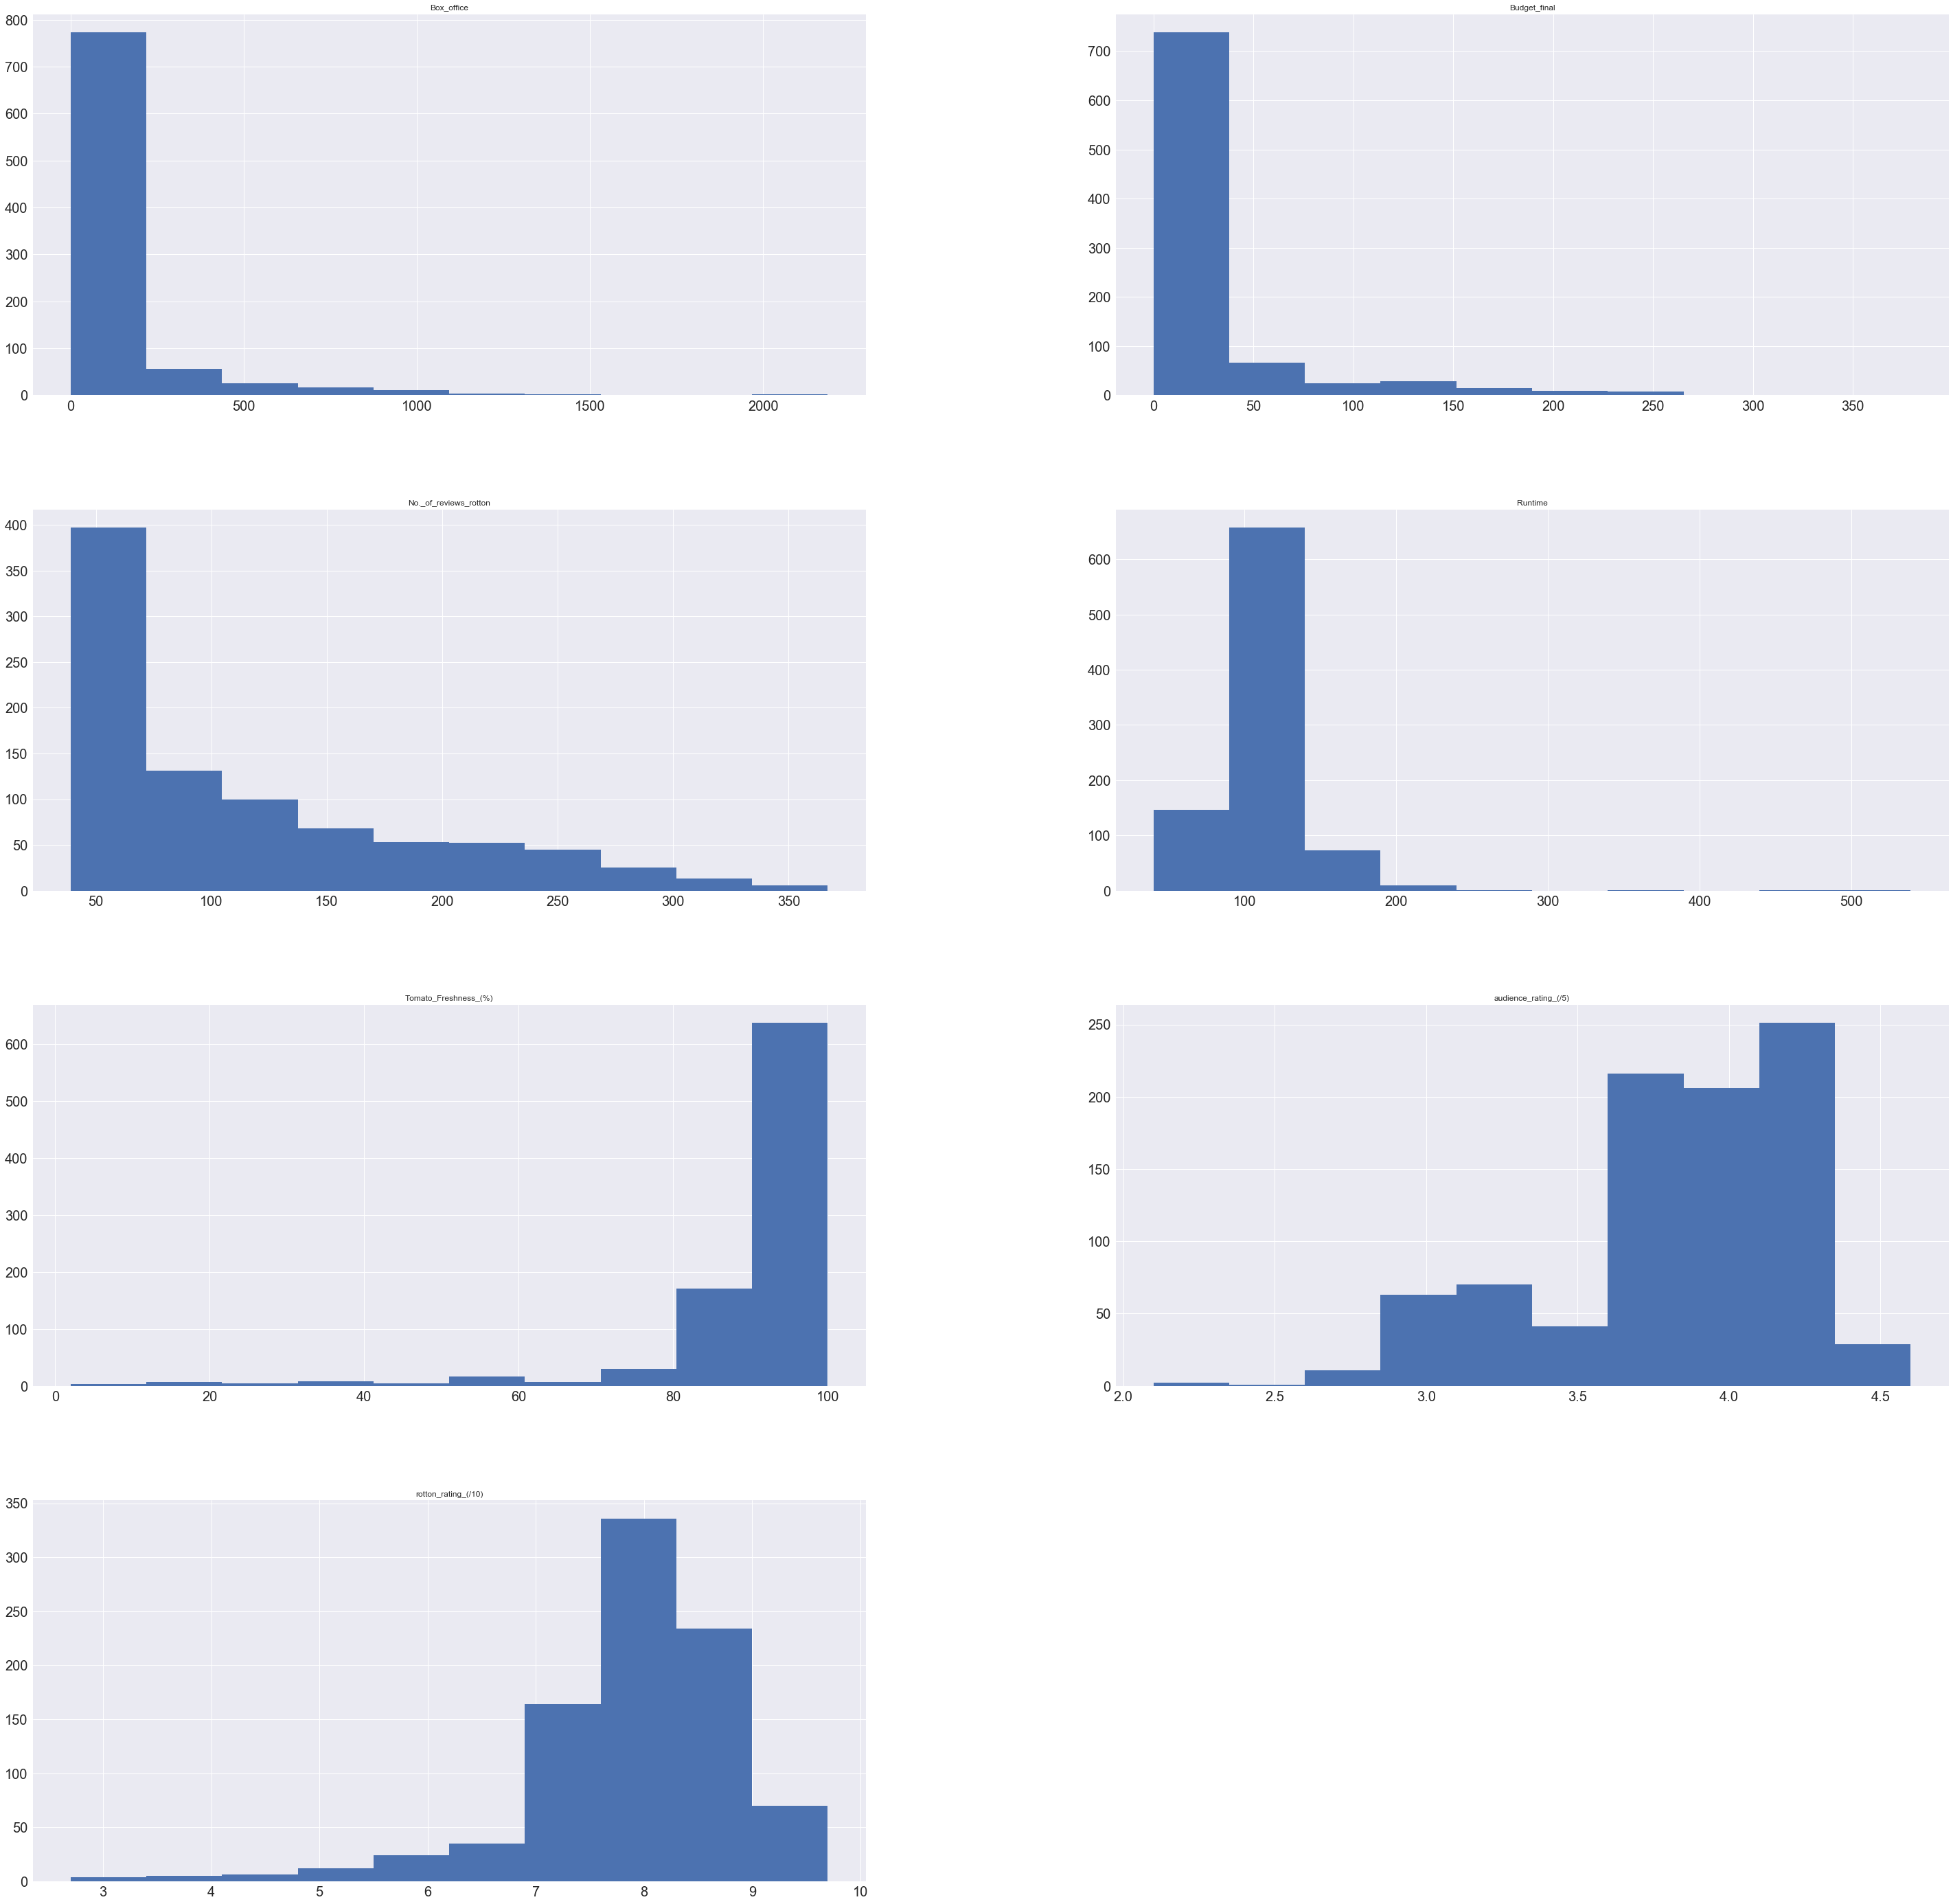

In [7]:
df.hist(layout=(4,2), figsize=(50,50))

From the above plots, we see that we have heavy skewness in all of our features and our target variable.

The features will be scaled using standard scaler.

When splitting the data into training and test. I will fit my scaler according to the training data!

There is no sign of multi-collinearity $(>= 0.9)$ - good to go!

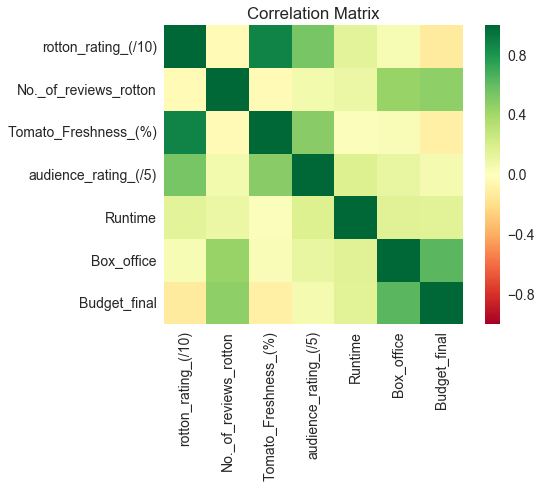

In [8]:
plot_corr_matrix(df)

In [9]:
X = unpickle_object("X_features_selection.pkl") #all features from the suffled dataframe. Numpy array
y = unpickle_object("y_variable_selection.pkl") #target variable from shuffled dataframe. Numpy array
final_df = unpickle_object("analysis_dataframe.pkl") #this is the shuffled dataframe!

## Baseline Model and Cross-Validation with Holdout Sets

### Creation of Holdout Set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0) #train on 75% of data

In [11]:
sc_X_train = StandardScaler()
sc_y_train = StandardScaler()

sc_X_train.fit(X_train[:,:6])#only need to learn fit of first 6 - rest are dummies
sc_y_train.fit(y_train)

X_train[:,:6] = sc_X_train.transform(X_train[:,:6]) #only need to transform first 6 columns - rest are dummies
X_test[:,:6] = sc_X_train.transform(X_test[:,:6]) #same as above

y_train = sc_y_train.transform(y_train)
y_test = sc_y_train.transform(y_test)

# Baseline Model

As we can see - the baseline model of regular linear regression is dreadful! Let's move on to more sophisticated methods!

In [12]:
baseline_model(X_train, X_test, y_train, y_test)

The R2 score of a basline regression model is -1.9775011421280398e+23

Mean squared error: 139458111276315616215040.00

Variance score: -197750114212803977936896.00

The top 3 features for predictive power according to the baseline model is ['Country_argentina', 'Country_finland', 'Country_mexico']


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Ridge, Lasso and Elastic Net regression - Holdouts

In [13]:
holdout_results = holdout_grid(["Ridge", "Lasso", "Elastic Net"], X_train, X_test, y_train, y_test)

In [14]:
pickle_object(holdout_results, "holdout_model_results")

# Cross-Validation - No Holdout Sets

In [15]:
sc_X = StandardScaler()
sc_y = StandardScaler()

In [16]:
sc_X.fit(X[:,:6])#only need to learn fit of first 6 - rest are dummies
sc_y.fit(y)

X[:,:6] = sc_X.transform(X[:,:6]) #only need to transform first 6 columns - rest are dummies
y = sc_y.transform(y)

In [17]:
no_holdout_results = regular_grid(["Ridge", "Lasso", "Elastic Net"], X, y)

In [18]:
pickle_object(no_holdout_results, "no_holdout_model_results")

# Analysis of Results!

# Ridge Analysis


The Model with no holdout set has a higher R2 of 0.4581898049882941. This is higher by 0.020384382171813153

The optimal parameters for this model are {'alpha': 107.5}

The mean cross validation score for all of the data is: 0.426813529439751

The most important features accordning to this model is ['Budget_final', 'No._of_reviews_rotton', 'Month_12']

Graphical Comparison below: 



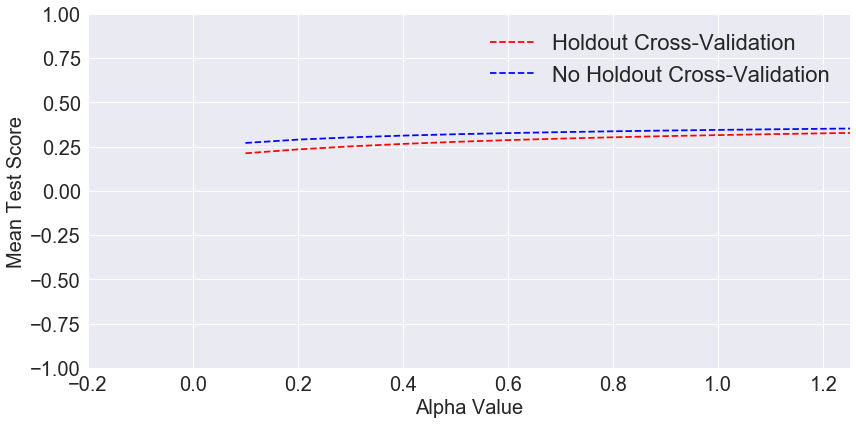

In [23]:
extract_model_comparisons(holdout_results, no_holdout_results, "Ridge")

# Lasso Analysis


The Model with the holdout set has a higher R2 of 0.4290751892395685. This is higher by 0.013850206355912664

The optimal parameters for this model are {'alpha': 0.10000000000000001}

The mean cross validation score on the test set is: 0.41774774276015764

The most important features accordning to this model is ['Budget_final', 'No._of_reviews_rotton', 'rotton_rating_(/10)']

Graphical Comparison below: 



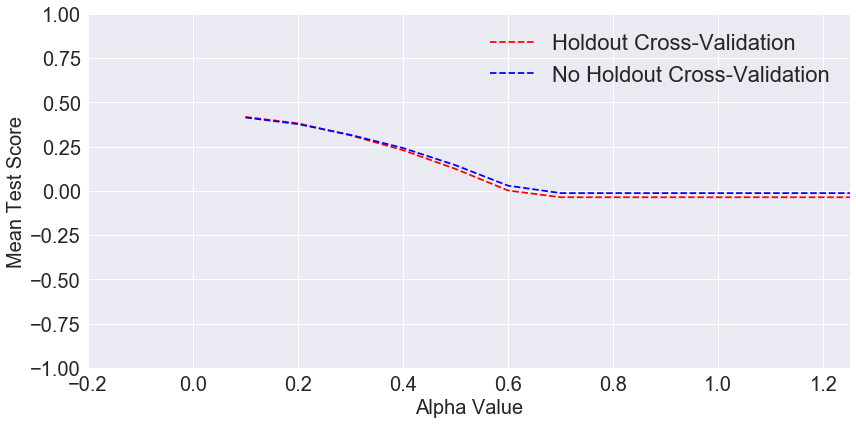

In [24]:
extract_model_comparisons(holdout_results, no_holdout_results, "Lasso")

# Elastic Net Analysis


The Model with no holdout set has a higher R2 of 0.4459659739120837. This is higher by 0.0027491346588406906

The optimal parameters for this model are {'alpha': 0.1, 'l1_ratio': 0.1}

The mean cross validation score for all of the data is: 0.42861943354426085

The most important features accordning to this model is ['Budget_final', 'No._of_reviews_rotton', 'rotton_rating_(/10)']

Graphical Comparison below: 



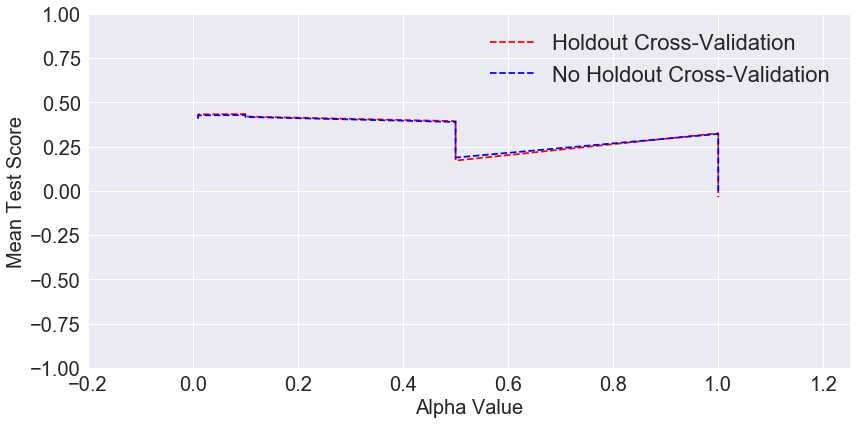

In [25]:
extract_model_comparisons(holdout_results, no_holdout_results, "Elastic Net")

From the above, we can see that 2/3 models had a higher $R^{2}$ without the use of a holdout set. This fit in line with the theory that when you use less data (i.e. use a hold-out set), you model will perform worse. As such, hold -out sets should only be implemented when a plethora of training data is available!

We also see that the budget feature and No. of Reviews on Rotton tomatoes were the strongest feature when predicting Box Office Revenue!

Please note: The data collection process was a nightmare with lots of missing data, as such, various methods of imputation were employed. This is probably most apparent from the fact that our highest $R^{2}$ across all models was $~0.45$.

While I did not obtain the strongest results, this project was fantastic in exposing me to methods of regularization, standardization and introductory machine learning techniques.

I am especially ecstatic that I got to use the GridSearchCV class! This class will make it very easy for me to take on more advanced machine learning topics in future projects.

Other than the focus on Machine Learning - this project was an excellent exercise in data collection and cleaning!